In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from IPython.display import Image

In [2]:
df = pd.read_csv('Loan_Modelling.csv')
df.isnull().values.any()

False

In [3]:
df.head(5)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


# Exploratory Data Analysis

In [5]:
df['Securities_Account'].value_counts()

0    4478
1     522
Name: Securities_Account, dtype: int64

In [6]:
df['Personal_Loan'].value_counts()

0    4520
1     480
Name: Personal_Loan, dtype: int64

As cited in the problem, we found that very few people have asked for loans meaning there are 4520 people on the liability side and 480 on the asset costumers side.

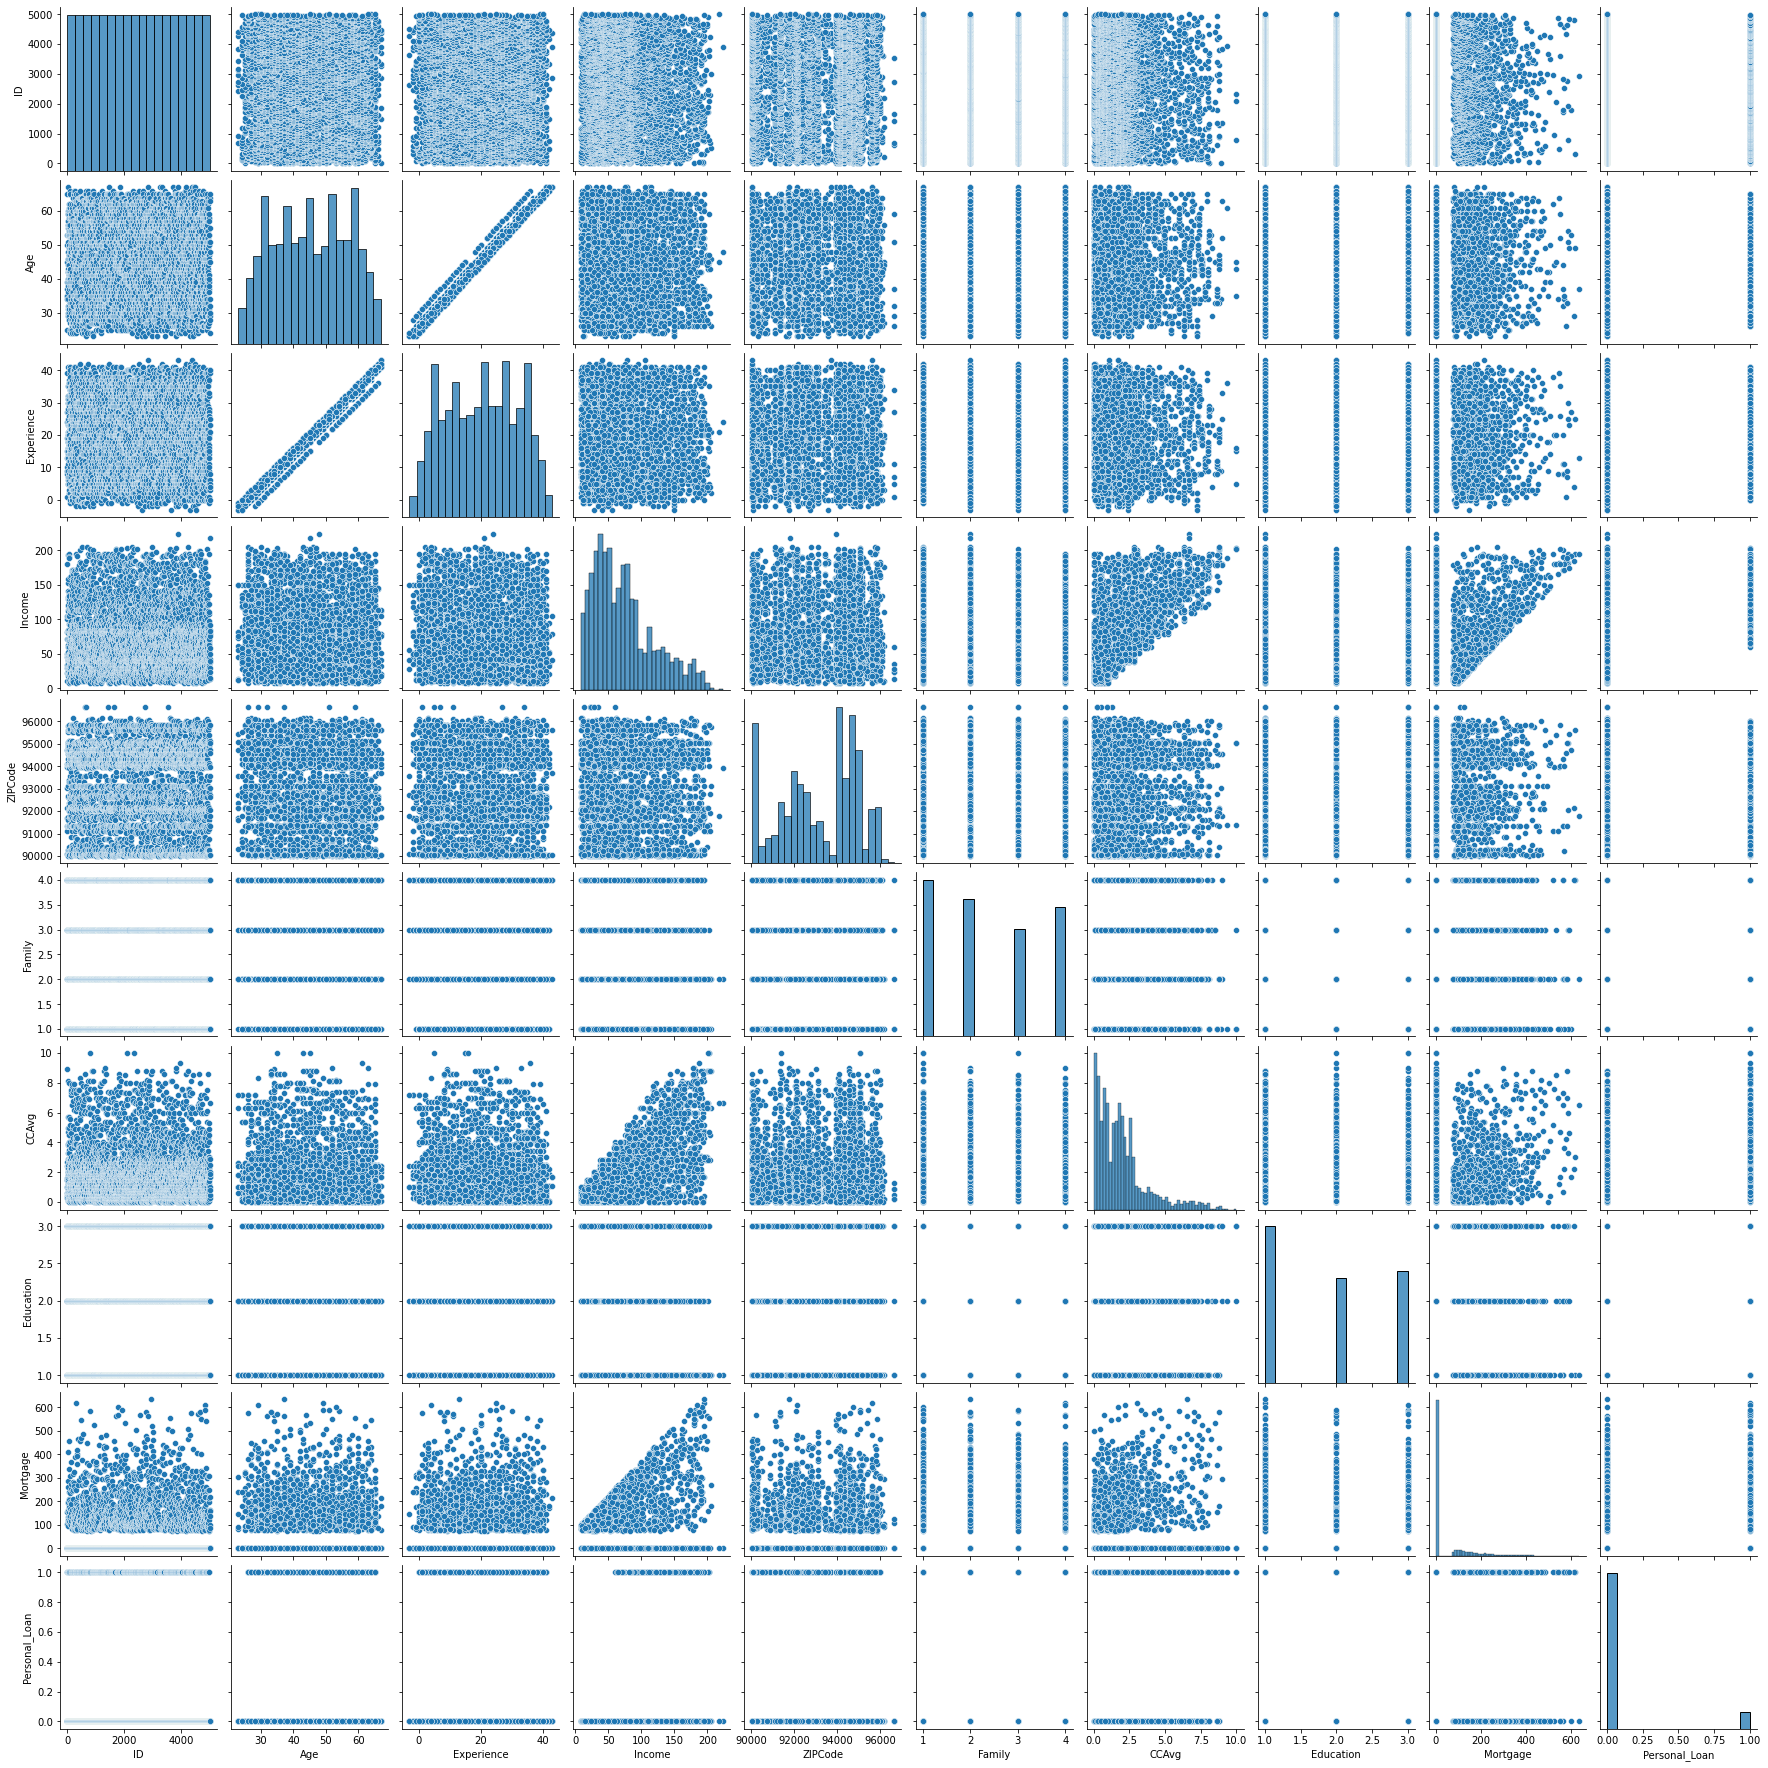

In [7]:
sns.pairplot(df.drop(['Securities_Account','CD_Account','Online','CreditCard'], axis=1))

We can see low correlation between certain variables except for the following:
1. Income & CCAvg
2. Income & Mortgage
3. Experience & Age

# Pre-processing

In [8]:
#I will fill the missing values of non-categorical columns with the mean of each column without counting the values 0. 
df['Age'] = df['Age'].replace(0,(df['Age']!=0).mean())
df['Experience'] = df['Experience'].replace(0,(df['Experience']!=0).mean())
df['Income'] = df['Income'].replace(0,(df['Income']!=0).mean())
df['Family'] = df['Family'].replace(0,(df['Family']!=0).mean())
df['CCAvg'] = df['CCAvg'].replace(0,(df['CCAvg']!=0).mean())
df['Mortgage'] = df['Mortgage'].replace(0,(df['Mortgage']!=0).mean())

I will deal with outliers by puting them within the whiskers

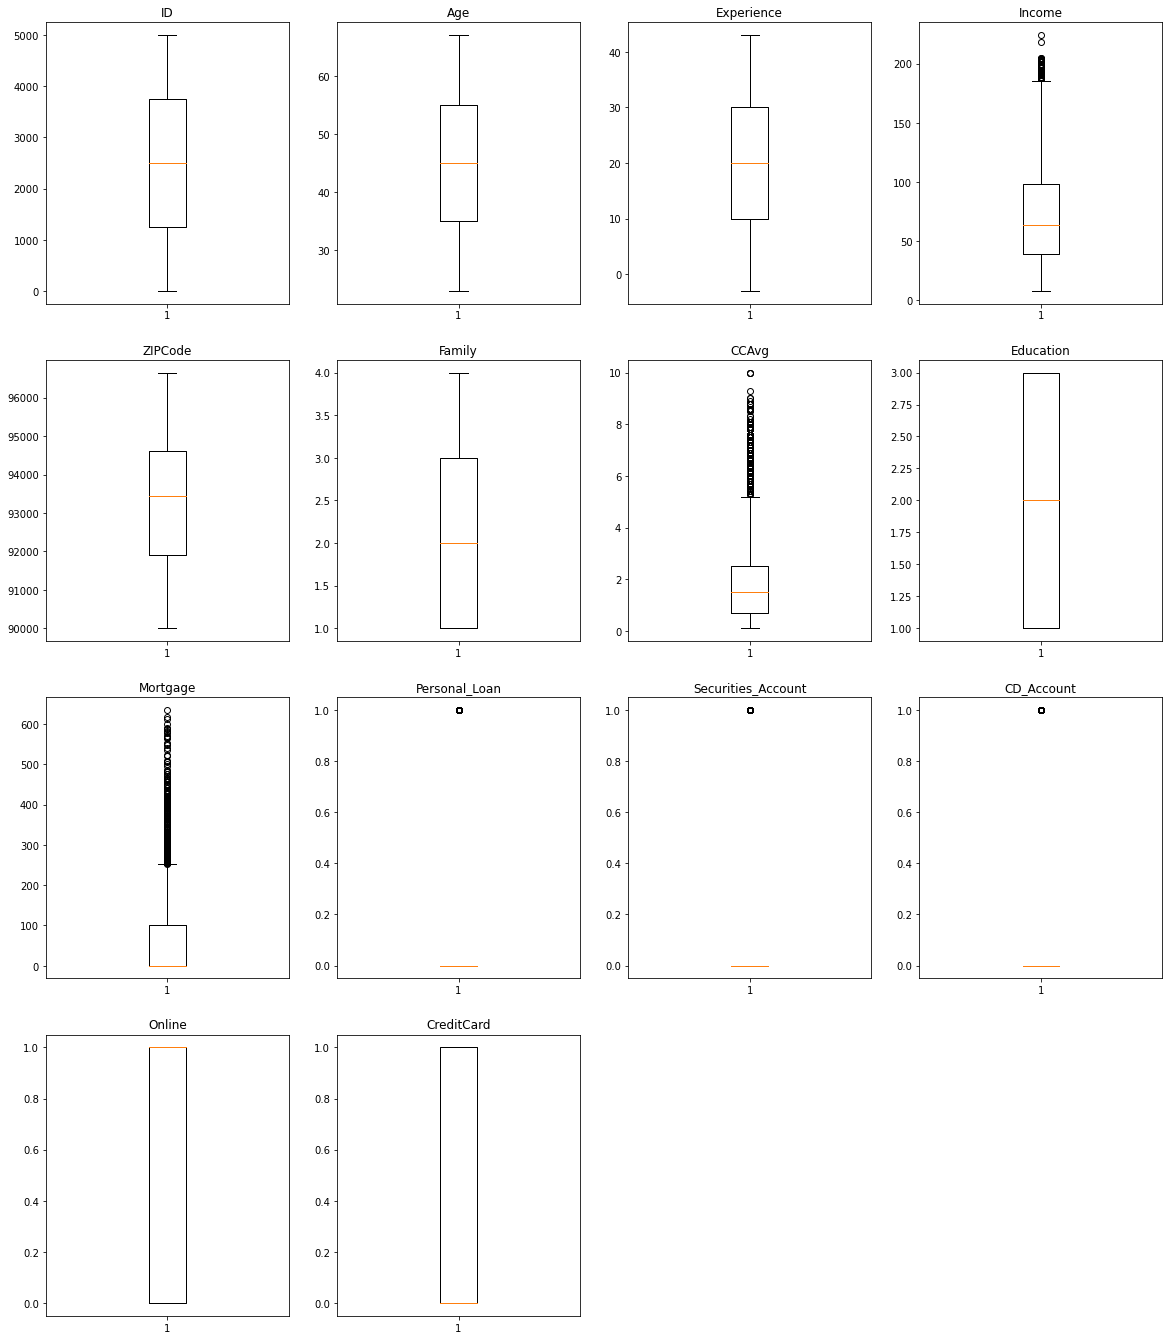

In [9]:
columns = df.columns
plt.subplots(figsize=(20,30))
for i, value in enumerate(columns):
    plt.subplot(5,4,i+1)
    plt.boxplot(df[value], whis=1.5)
    plt.title(value)
    plt.show

In [10]:
def treating_outliers (df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1
    lw = Q1-1.5*IQR
    uw = Q3+1.5*IQR
    
    df[col]=np.clip(df[col],lw,uw)
    
    return df

treating_outliers(df,'Mortgage')
treating_outliers(df,'CCAvg')
treating_outliers(df,'Income')

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1.0,49.0,91107,4,1.6,1,0.3076,0,1,0,0,0
1,2,45,19.0,34.0,90089,3,1.5,1,0.3076,0,1,0,0,0
2,3,39,15.0,11.0,94720,1,1.0,1,0.3076,0,0,0,0,0
3,4,35,9.0,100.0,94112,1,2.7,2,0.3076,0,0,0,0,0
4,5,35,8.0,45.0,91330,4,1.0,2,0.3076,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3.0,40.0,92697,1,1.9,3,0.3076,0,0,0,1,0
4996,4997,30,4.0,15.0,92037,4,0.4,1,85.0000,0,0,0,1,0
4997,4998,63,39.0,24.0,93023,2,0.3,3,0.3076,0,0,0,0,0
4998,4999,65,40.0,49.0,90034,3,0.5,2,0.3076,0,0,0,1,0


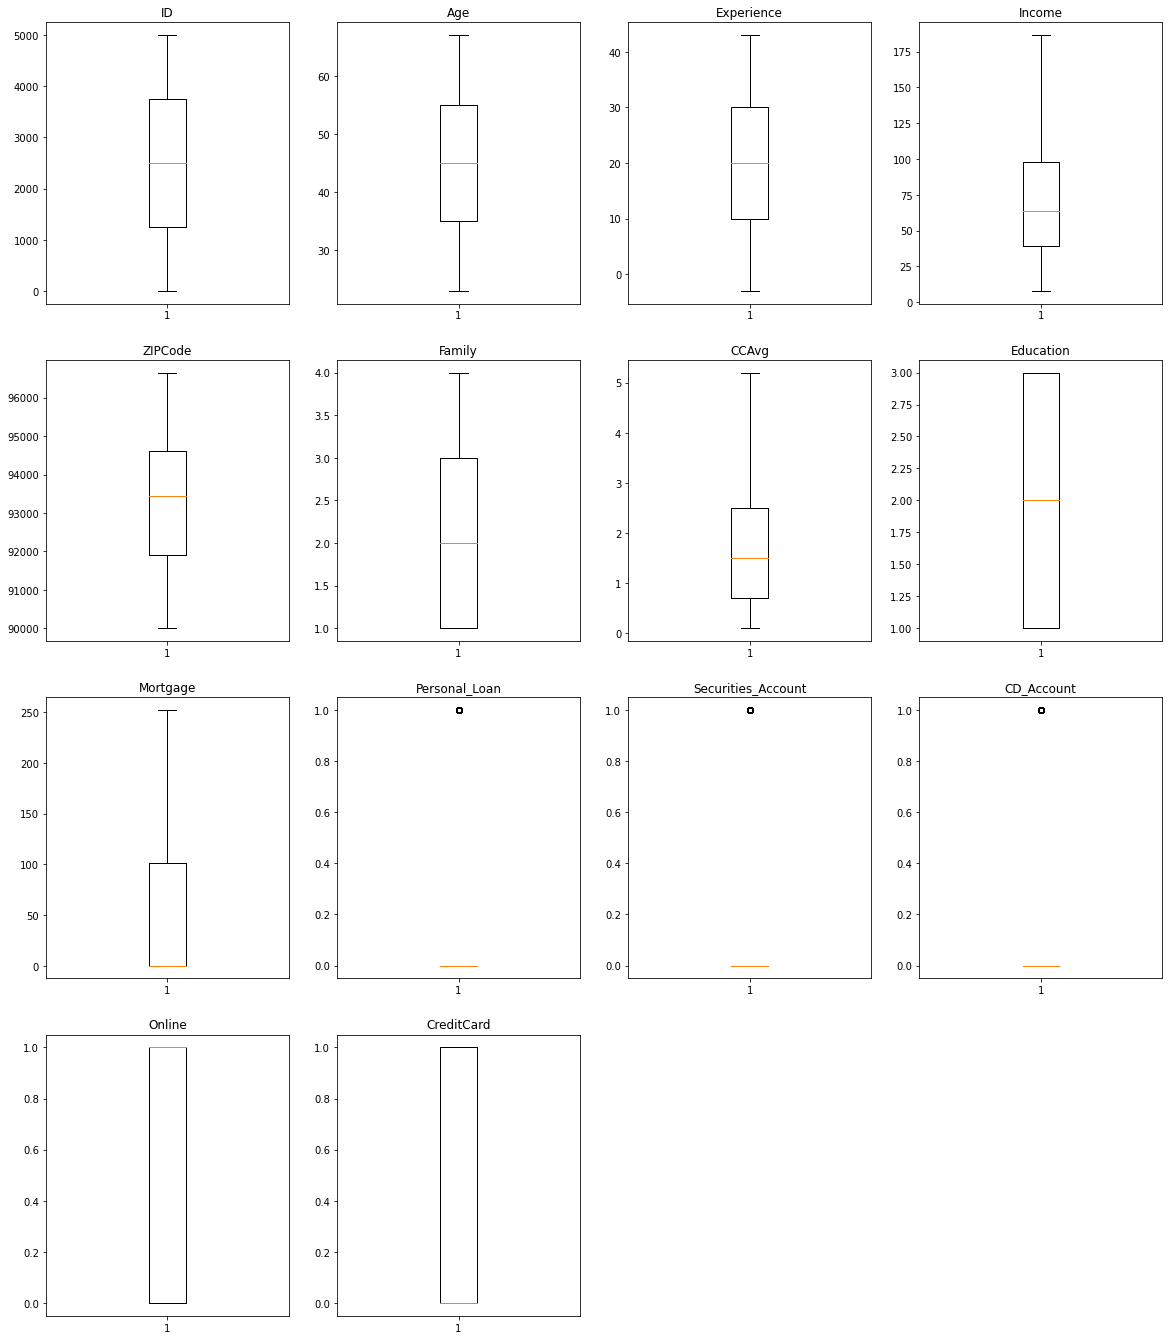

In [11]:
plt.subplots(figsize=(20,30))
for i, value in enumerate(columns):
    plt.subplot(5,4,i+1)
    plt.boxplot(df[value], whis=1.5)
    plt.title(value)
    plt.show

# Logistic Regression

In [12]:
x = df.drop(['Personal_Loan','Mortgage','ZIPCode','ID'], axis=1)
y = df['Personal_Loan']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 1)
x_train.head(5)

,Age,Experience,Income,Family,CCAvg,Education,Securities_Account,CD_Account,Online,CreditCard
1334,47,22.0,35.0,2,1.3,1,0,0,1,0
4768,38,14.0,39.0,1,2.0,2,0,0,1,0
65,59,35.0,131.0,1,3.8,1,0,0,1,1
177,29,3.0,65.0,4,1.8,2,0,0,0,0
4489,39,13.0,21.0,3,0.2,2,0,0,1,0


In [14]:
log_reg = LogisticRegression(solver='liblinear')
model = log_reg.fit(x_train, y_train.ravel())

y_predict = model.predict(x_test)

In [15]:
coef_df = pd.DataFrame(np.append(model.coef_[0],model.intercept_[0]), 
                      index = x_train.columns.tolist() + ['Intercept'],
                      columns = ['Coefficients'])
coef_df

,Coefficients
Age,-0.442928
Experience,0.444268
Income,0.050455
Family,0.687626
CCAvg,0.375918
Education,1.740444
Securities_Account,-0.866949
CD_Account,3.182667
Online,-0.583590
CreditCard,-0.981807


In [16]:
import statsmodels.api as sm

X = sm.add_constant(x)

X_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=1)

olsmod0 = sm.OLS(y_train1, X_train1)
olsres0 = olsmod0.fit()
olsres0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Personal_Loan   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     228.6
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:10:47   Log-Likelihood:                 216.66
No. Observations:                3500   AIC:                            -411.3
Df Residuals:                    3489   BIC:                            -343.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1984      0.082     -2.409      0.016      -0.360      -0.037
Age                   -0.0068      0.003     -2.072      0.038      -0.013      -0.000
Experience             0.0070      0.003      2.142      0.032       0.001       0.013
Income                 0.0028      0.000     24.611      0.000       0.003       0.003
Family                 0.0335      0.003      9.796      0.000       0.027       0.040
CCAvg                  0.0245      0.004      6.882      0.000       0.018       0.031
Education              0.0756      0.005     15.583      0.000       0.066       0.085
Securities_Account    -0.0716      0.013     -5.322      0.000      -0.098      -0.045
CD_Account             0.3299      0.018     17.847      0.000       0.294       0.366
Online                -0.0248      0.008     -3.108      0.002      -0.040      -0.009
CreditCard            -0.0451      0.009     -5.086      0.000      -0.063      -0.028
==============================================================================
Omnibus:                      888.399   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2246.455
Skew:                           1.373   Prob(JB):                         0.00
Kurtosis:                       5.804   Cond. No.                     2.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
model.intercept_

array([-2.42627887])

In [18]:
model_score = model.score(x_test, y_test)
print(model_score)

0.9466666666666667


In [19]:
cm = metrics.confusion_matrix(y_test, y_predict, labels=[1,0])
cm

array([[  87,   62],
       [  18, 1333]], dtype=int64)

In [20]:
recall = 87/(87+18)
print('recall is:',recall)
precission = 87/(87+62)
print('precission is:',precission)
accuracy = (87+1333)/(87+62+18+1333)
print('accuracy is:',accuracy)

recall is: 0.8285714285714286
precission is: 0.5838926174496645
accuracy is: 0.9466666666666667


We have a good model which fits 94.6%, has a recall of 82.8%, and 58.3% precission which is my main focus, I deleted the Mortgage column since it gave a hight p-value and it got the precission up 2%.

# Model Building - Decission Tree

In [21]:
dtree = DecisionTreeClassifier(criterion = 'gini', random_state = 1)
dtree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

In [22]:
print('the score for the train data is:', dtree.score(x_train, y_train))
print('the score for the test data is:', dtree.score(x_test, y_test))

the score for the train data is: 1.0
the score for the test data is: 0.9813333333333333


In [23]:
y_predict1 = dtree.predict(x_test)
cm1 = metrics.confusion_matrix(y_test, y_predict1)
cm1

array([[1338,   13],
       [  15,  134]], dtype=int64)

In [24]:
pred_train = dtree.predict(x_train)
pred_test = dtree.predict(x_test)
print(metrics.recall_score(y_train, pred_train))
print(metrics.recall_score(y_test, pred_test))

1.0
0.8993288590604027


I can see that the results have bettered and that now my Recall is closer to what I would want it to be.

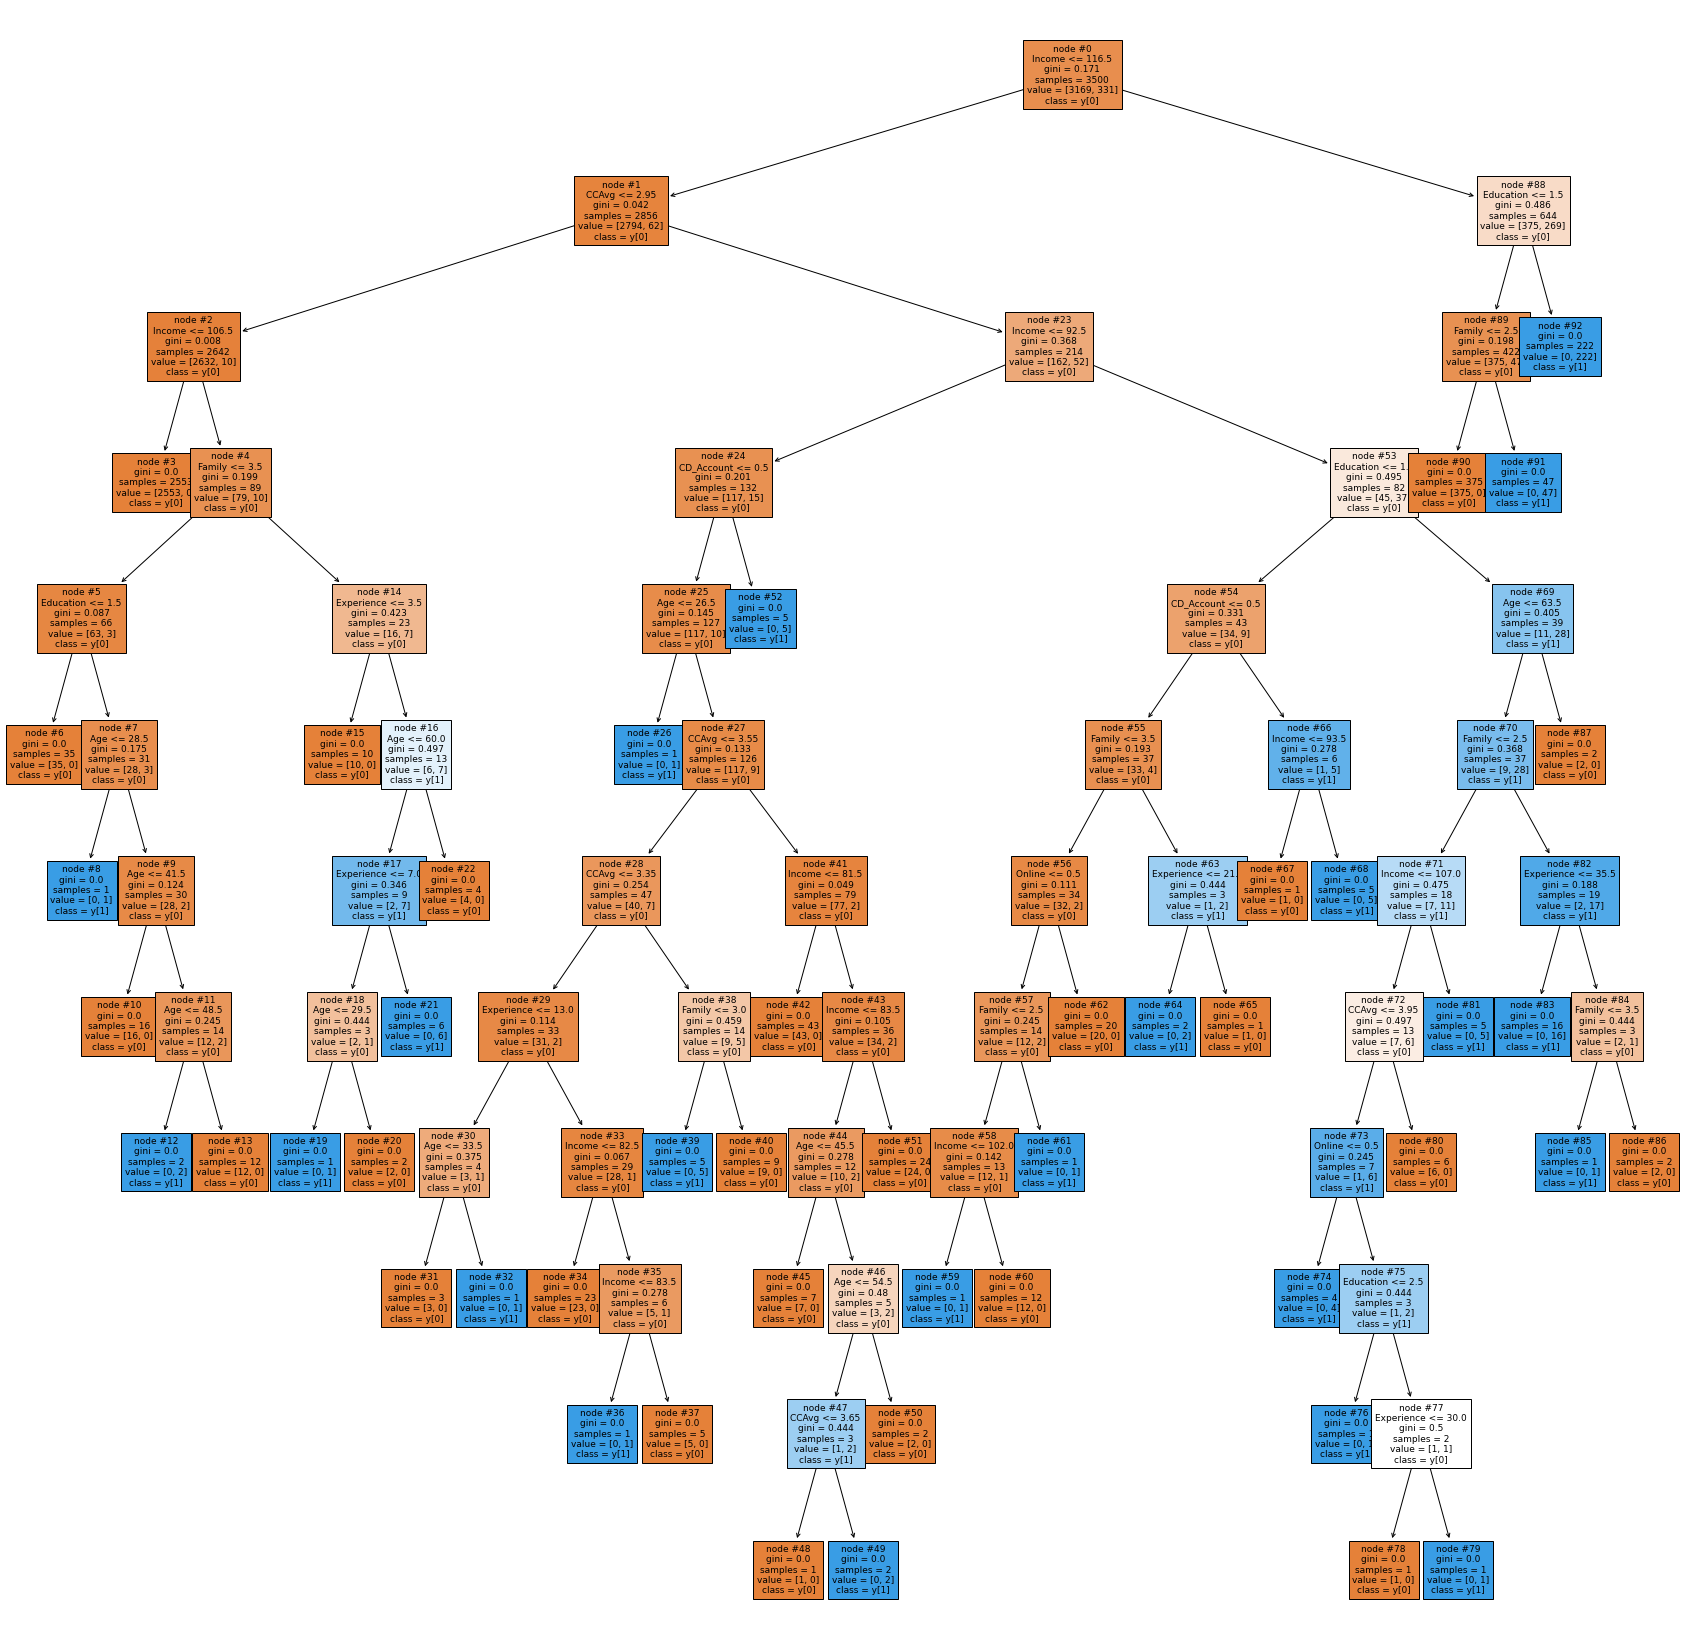

In [25]:
feature_names = list(x.columns)
plt.subplots(figsize=(30,30))
tree.plot_tree(dtree, feature_names = feature_names, fontsize = 9, filled = True, node_ids=True, class_names = True)
plt.show()

# Pre-pruning

Since there are way to many nods, I will simplify the tree by adding hyper-parameters.

In [26]:
dtree1 = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, random_state = 1)
dtree1.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [27]:
y_predict2 = dtree1.predict(x_test)
cm2 = metrics.confusion_matrix(y_test, y_predict2)
cm2

array([[1343,    8],
       [  20,  129]], dtype=int64)

In [28]:
pred_train1 = dtree1.predict(x_train)
pred_test1 = dtree1.predict(x_test)
print(metrics.recall_score(y_train, pred_train1))
print(metrics.recall_score(y_test, pred_test1))

0.9123867069486404
0.8657718120805369


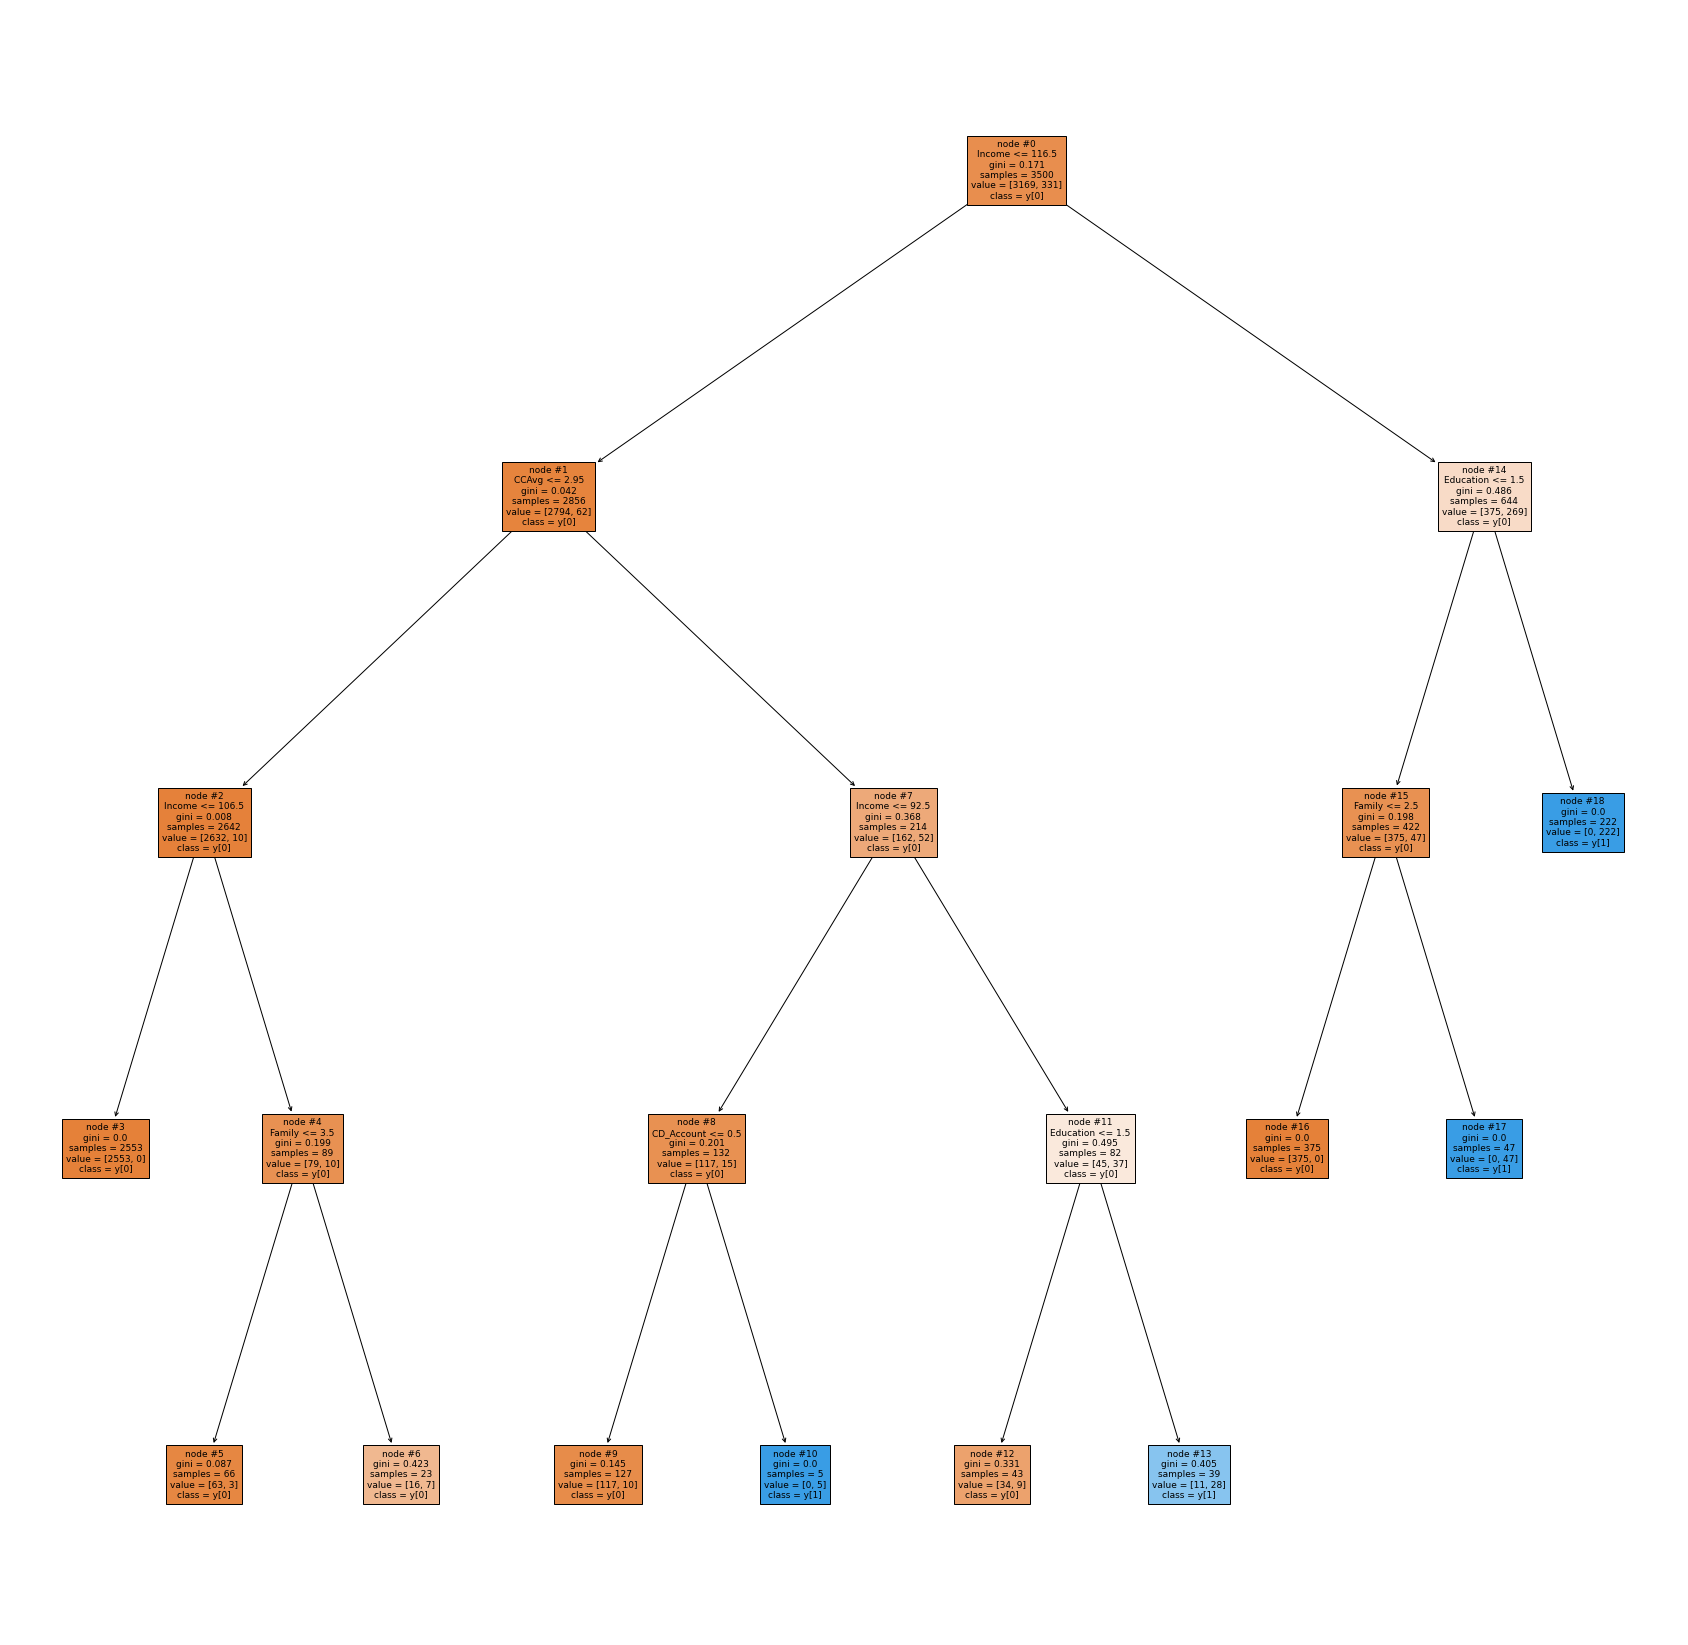

In [29]:
plt.subplots(figsize=(30,30))
tree.plot_tree(dtree1, feature_names = feature_names, fontsize = 9, filled = True, node_ids=True, class_names = True)
plt.show()

In [30]:
from sklearn.model_selection import GridSearchCV

# choose the type of classifier
estimator = DecisionTreeClassifier(random_state=1)

#put all parameters in a list so it runs them all
parameters = {
    'max_depth': np.arange(1,10),
    'min_samples_leaf': [1,2,5,7,10,15,20],
    'max_leaf_nodes': [2,3,5,10],
    'min_impurity_decrease': [0.001,0.01,0.1],
}

#get a score for each of the combinations
acc_score = metrics.make_scorer(metrics.recall_score)


grid_job = GridSearchCV(estimator, parameters, scoring = acc_score, )
grid_job = grid_job.fit(x_train, y_train)

# find the best estimator
estimator = grid_job.best_estimator_

estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, random_state=1)

In [31]:
y_predict3 = estimator.predict(x_test)
cm3 = metrics.confusion_matrix(y_test, y_predict3)
cm3

array([[1341,   10],
       [  18,  131]], dtype=int64)

In [32]:
pred_train2 = estimator.predict(x_train)
pred_test2 = estimator.predict(x_test)
print(metrics.recall_score(y_train, pred_train2))
print(metrics.recall_score(y_test, pred_test2))

0.9274924471299094
0.8791946308724832


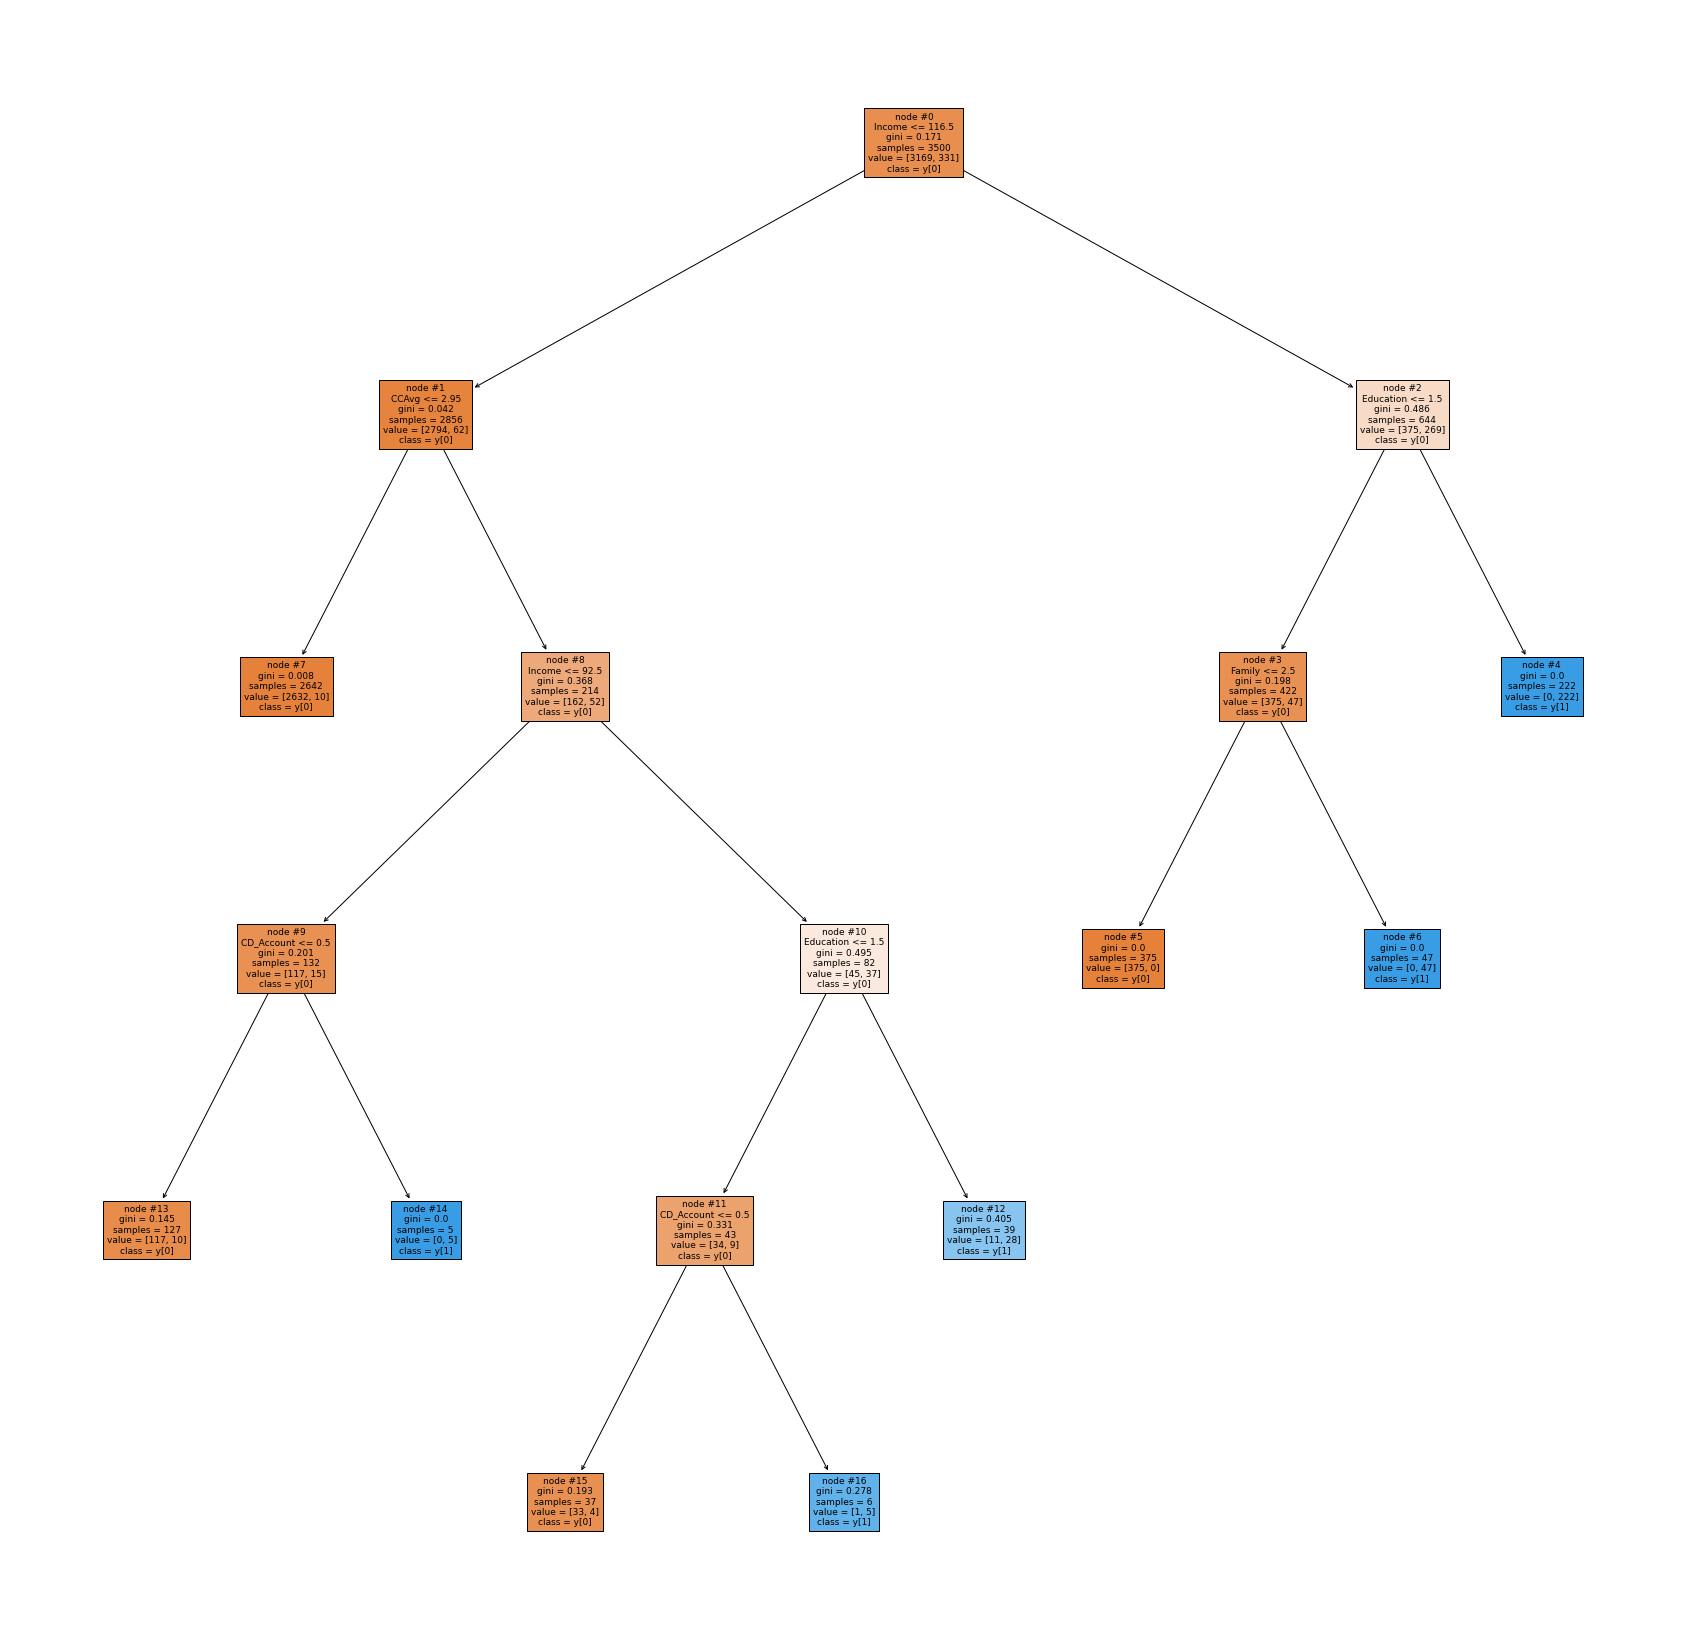

In [33]:
plt.subplots(figsize=(30,30))
tree.plot_tree(estimator, feature_names = feature_names, fontsize = 9, filled = True, node_ids=True, class_names = True)
plt.show()

In [34]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [35]:
df_path = pd.DataFrame(path)

<AxesSubplot:xlabel='ccp_alphas', ylabel='impurities'>

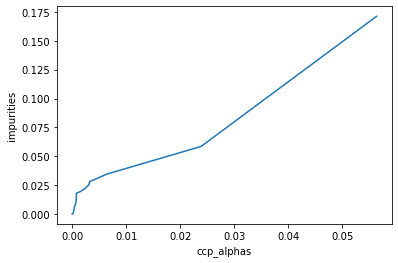

In [36]:
sns.lineplot(data=df_path,x=df_path['ccp_alphas'],y=df_path['impurities'])

# Post-pruning

In [37]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

In [38]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

In [39]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0004090909090909093, random_state=1)


In [40]:
recall_train = []

for clf in clfs:
    pred_train3 = clf.predict(x_train)
    value = metrics.recall_score(y_train, pred_train3)
    recall_train.append(value)
    
recall_test = []

for clf in clfs:
    pred_test3 = clf.predict(x_test)
    value = metrics.recall_score(y_test, pred_test3)
    recall_test.append(value)

In [41]:
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0007501170508689307, random_state=1)


In [42]:
y_predict4 = best_model.predict(x_test)
cm4 = metrics.confusion_matrix(y_test, y_predict4)
cm4

array([[1341,   10],
       [  14,  135]], dtype=int64)

In [43]:
pred_train3 = best_model.predict(x_train)
pred_test3 = best_model.predict(x_test)
print(metrics.recall_score(y_train, pred_train3))
print(metrics.recall_score(y_test, pred_test3))
print(metrics.precision_score(y_test, pred_test3))

0.9667673716012085
0.9060402684563759
0.9310344827586207


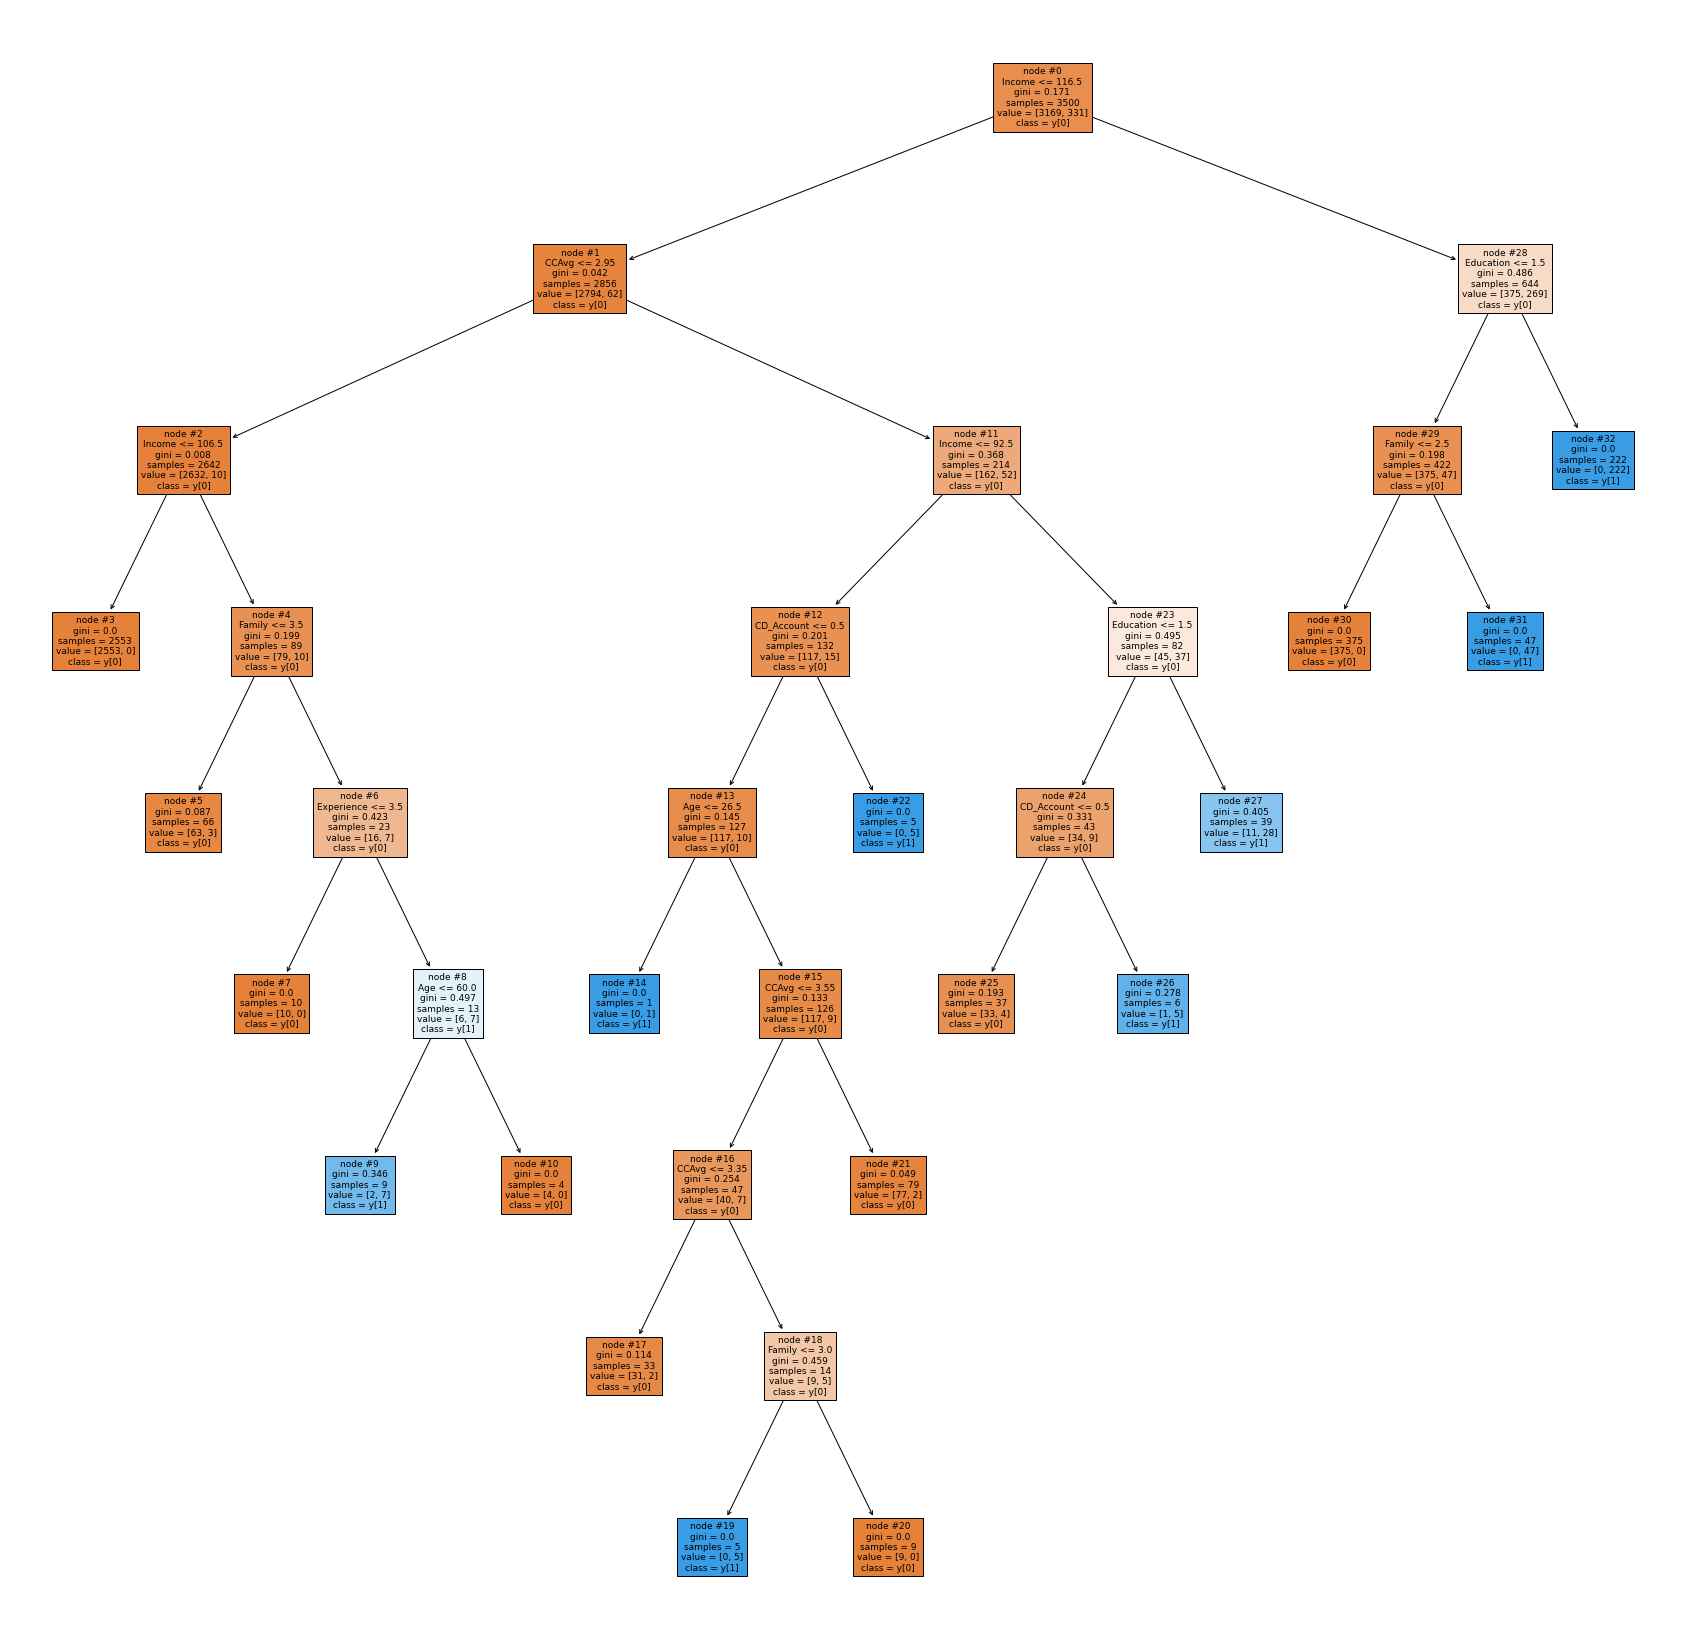

In [44]:
plt.subplots(figsize=(30,30))
tree.plot_tree(best_model, feature_names = feature_names, fontsize = 9, filled = True, node_ids=True, class_names = True)
plt.show()

Decision Tree post pruning gives out the best result having a larger tree. it has a recall of 90% and I will keep this last one.

In [72]:
pd.DataFrame(best_model.feature_importances_, columns = ['Imp'], index = x_train.columns).sort_values(by='Imp', ascending=False)

,Imp
Education,0.430462
Income,0.319735
Family,0.165225
CCAvg,0.045288
CD_Account,0.024353
Age,0.009066
Experience,0.005871
Securities_Account,0.000000
Online,0.000000
CreditCard,0.000000


In [45]:
TN = x_test[(y_test == 1) & (y_predict4== 1)]
TP = x_test[(y_test == 0) & (y_predict4== 0)]

In [48]:
correct = pd.concat([TP,TN])
correct.head(5)

,Age,Experience,Income,Family,CCAvg,Education,Securities_Account,CD_Account,Online,CreditCard
2764,31,5.0,84.0,1,2.9,3,0,0,0,1
4767,35,9.0,45.0,3,0.9,1,1,0,0,0
3814,34,9.0,35.0,3,1.3,1,0,0,0,0
3499,49,23.0,114.0,1,0.3,1,0,0,1,0
2735,36,12.0,70.0,3,2.6,2,0,0,1,0


In [62]:
df_avg = {'CCAvg': df['CCAvg'].mean(),
         'Experience': df['Experience'].mean(),
         'Income': df['Income'].mean(),
         'Age': df['Age'].mean()}

corr_avg = {'CCAvg': correct['CCAvg'].mean(),
         'Experience': correct['Experience'].mean(),
         'Income': correct['Income'].mean(),
         'Age': correct['Age'].mean()}

diff_df_corr = pd.DataFrame([corr_avg,df_avg])

In [63]:
diff_df_corr

,CCAvg,Experience,Income,Age
0,1.830774,19.884627,73.566057,45.100949
1,1.852089,20.117626,73.617400,45.338400


# Actionable insights & recomendations

Logistic Regresion's recall is: 0.8285714285714286

Logistic Regresion's precission is: 0.5838926174496645

Decision Tree's recall is: 0.9060402684563759

Decision Tree's precision is: 0.9310344827586207

The difference is a lot, especially in the Decision Tree's precission. 

Variables like CCAvg, Experience, Income, Education and Age are sligthly above average in the 'correct' Dat Frame given by the Decision Tree and the coefficients of the Logistic Regression, looking out for these characteristics is therefore sugested when looking for a good loan candidate. 

The importance showed us the order of each variables influence for making the decision tree as it is and so this is the order we should look at future clients characteristics and the level of the variables's importance:
1. Education	0.430462
2. Income	0.319735
3. Family	0.165225
4. CCAvg	0.045288
5. CD_Account	0.024353
6. Age	0.009066
7. Experience	0.005871



# Exploratory Analysis on the incorrectly predicted

In [58]:
FN = x_test[(y_test == 1) & (y_predict4== 0)]
FP = x_test[(y_test == 0) & (y_predict4== 1)]

In [59]:
error = pd.concat([FP,FN])
error.shape

(24, 10)

In [60]:
err_avg = {'CCAvg': error['CCAvg'].mean(),
         'Experience': error['Experience'].mean(),
         'Income': error['Income'].mean(),
         'Age': error['Age'].mean()}


diff_df = pd.DataFrame([err_avg,df_avg])

In [61]:
diff_df

,CCAvg,Experience,Income,Age
0,3.010417,20.333333,99.833333,45.791667
1,1.852089,20.117626,73.617400,45.338400


I found that people on the errors have a higher spending on their credit cards than average and the income is also higher on the error than the original average.

original data on education:


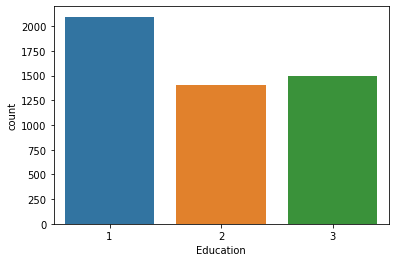

error data on education:


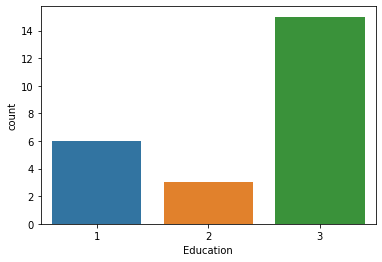

In [54]:
print('original data on education:')
sns.countplot(df['Education'])
plt.show()
print('error data on education:')
sns.countplot(error['Education'])
plt.show()

I can see tht the advanced education was overlooked as lower levels of education wehnt through better having more people on that level.

original data:


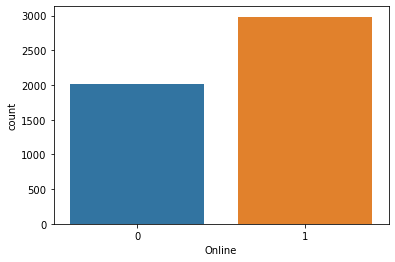

error data :


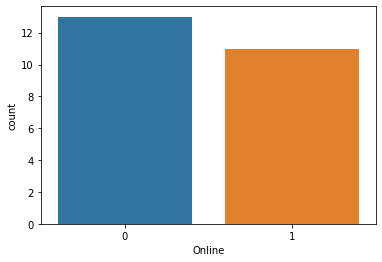

In [55]:
print('original data:')
sns.countplot(df['Online'])
plt.show()
print('error data :')
sns.countplot(error['Online'])
plt.show()

The prediction got a higher error on offline people.